In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
def generate_result(auc_b_c, auc_b_light, auc_c_light, label=""):
    result = {}
    result['b vs c'] = [auc_b_c]
    result['b vs light'] = [auc_b_light]
    result['c vs light'] = [auc_c_light]
    result['name'] = [label]
    return pandas.DataFrame(result)

In [3]:
import root_numpy
import pandas
from rep.data import LabeledDataStorage
#from hep_ml.decisiontrain import DecisionTrainClassifier, DecisionTrainRegressor
from hep_ml.losses import LogLossFunction, MSELossFunction
from rep.metaml import FoldingClassifier, FoldingRegressor
from rep.report import ClassificationReport
from rep.report.metrics import RocAuc
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

## Read data

In [8]:
treename = 'tag'

data_b = pandas.DataFrame(root_numpy.root2array('datasets/type=5.root', treename=treename)).dropna()
data_b = data_b[::90]
data_c = pandas.DataFrame(root_numpy.root2array('datasets/type=4.root', treename=treename)).dropna()
data_light = pandas.DataFrame(root_numpy.root2array('datasets/type=0.root', treename=treename)).dropna()
data_light = data_light[::2]

In [9]:
data = {'b': data_b, 'c': data_c, 'light': data_light}

### Add features

In [10]:
for d in data.values():
    d['log_SVFDChi2'] = numpy.log(d['SVFDChi2'].values)
    d['log_SVSumIPChi2'] = numpy.log(d['SVSumIPChi2'].values)

In [11]:
len(data_b), len(data_c), len(data_light)

(20485, 19941, 21212)

In [12]:
jet_features = [column for column in data_b.columns if "Jet" in column]
sv_features = [column for column in data_b.columns if "SV" in column]

In [13]:
print "Jet features", ", ".join(jet_features)
print "SV features", ", ".join(sv_features)

Jet features JetParton, JetFlavor, JetPx, JetPy, JetPz, JetE, JetQ, JetSigma1, JetSigma2, JetMult, JetPTHard, JetPTD, JetNDis
SV features SVM, SVMC, SVR, SVPT, SVDR, SVN, SVQ, SVFDChi2, SVSumIPChi2, log_SVFDChi2, log_SVSumIPChi2


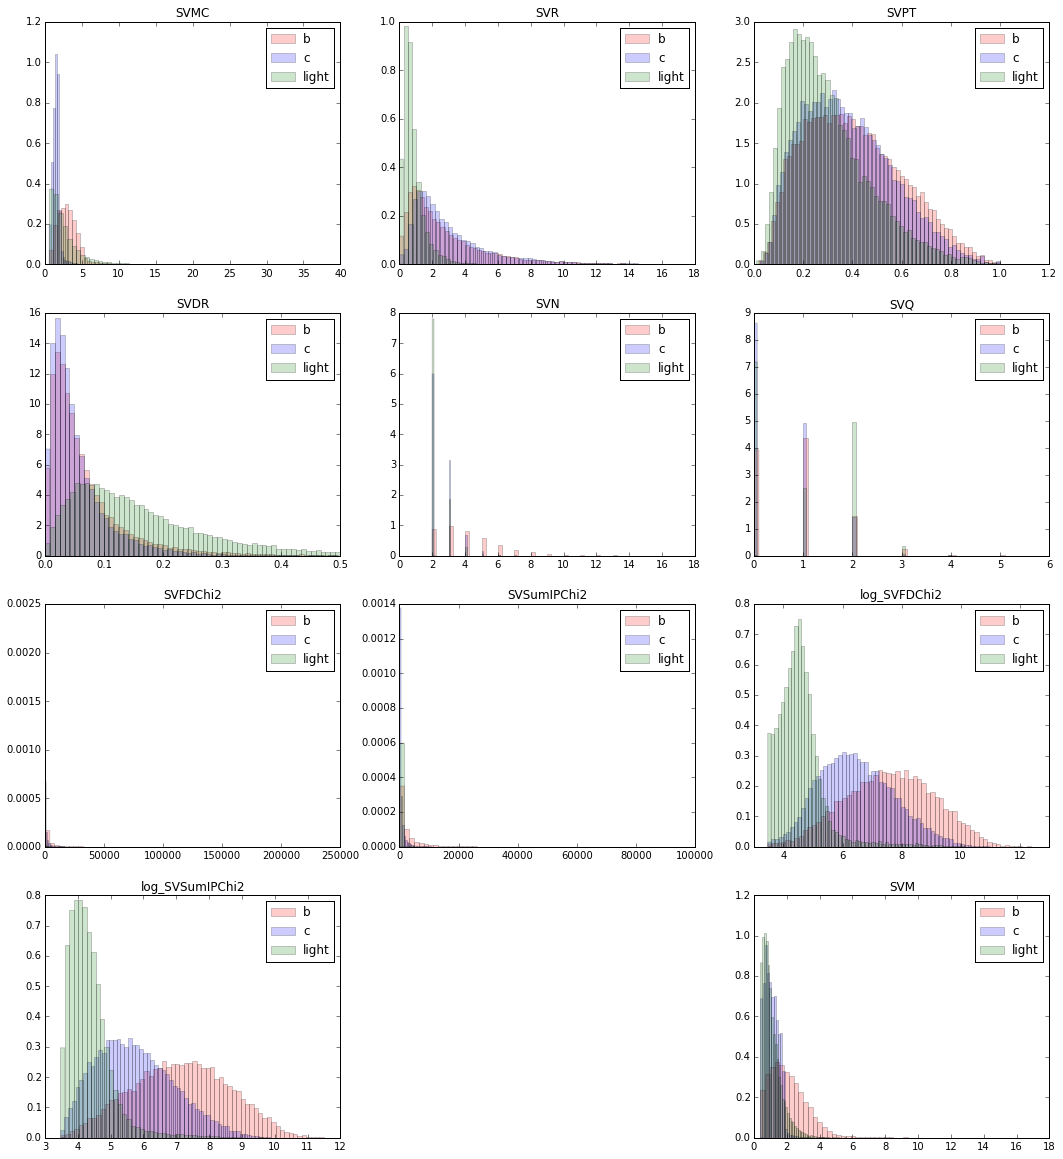

In [14]:
figsize(18, 20)
for i, feature in enumerate(sv_features):
    subplot(len(sv_features) / 3 + 1, 3, i)
    hist(data_b[feature].values, label='b', alpha=0.2, bins=60, normed=True)
    hist(data_c[feature].values, label='c', alpha=0.2, bins=60, normed=True)
    hist(data_light[feature].values, label='light', alpha=0.2, bins=60, normed=True)
    title(feature); legend(loc='best'); 

In [15]:
figsize(8, 6)

# Old scheme

## Prepare datasets:
* b vs c
* b, c vs light

In [16]:
data_b_c_lds = LabeledDataStorage(pandas.concat([data_b, data_c]), [1] * len(data_b) + [0] * len(data_c))
data_bc_light_lds = LabeledDataStorage(pandas.concat([data_b, data_c, data_light]), 
                                       [1] * len(data_b) + [1] * len(data_c) + [0] * len(data_light))

### b vs c jets

In [96]:
# tt_base = RandomForestClassifier(n_estimators=100, max_depth=None, max_features='auto')
tt_base = XGBoostClassifier(n_estimators=100, colsample=0.7, eta=0.1, nthreads=8, 
                             subsample=0.5, max_depth=8)
tt_folding_b_c = FoldingClassifier(tt_base, n_folds=2, random_state=11, 
                                   features=sv_features)
%time tt_folding_b_c.fit_lds(data_b_c_lds)
pass

CPU times: user 14.3 s, sys: 2.2 s, total: 16.5 s
Wall time: 7.66 s


In [97]:
report = ClassificationReport({'b vs c': tt_folding_b_c}, data_b_c_lds)

KFold prediction using folds column


In [98]:
auc_b_c = report.compute_metric(RocAuc())['b vs c']

### b, c vs light jets

In [99]:
# tt_base = RandomForestClassifier(n_estimators=100, max_depth=None, max_features='auto')
tt_base = XGBoostClassifier(n_estimators=100, colsample=0.7, eta=0.1, nthreads=8, 
                             subsample=0.5, max_depth=8)
tt_folding_bc_light = FoldingClassifier(tt_base, n_folds=2, random_state=11, features=sv_features)
%time tt_folding_bc_light.fit_lds(data_bc_light_lds)
pass

CPU times: user 22.6 s, sys: 2.63 s, total: 25.2 s
Wall time: 10.6 s


In [100]:
report = ClassificationReport({'tt b, c vs light': tt_folding_bc_light}, data_bc_light_lds)

KFold prediction using folds column


In [101]:
report.compute_metric(RocAuc())

OrderedDict([('tt b, c vs light', 0.9772539178240145)])

In [102]:
p_b_c = tt_folding_b_c.predict_proba(pandas.concat([data_b, data_c]))[:, 1]
p_b_c_light = tt_folding_b_c.predict_proba(data_light)[:, 1]
p_bc_light = tt_folding_bc_light.predict_proba(pandas.concat([data_b, data_c, data_light]))[:, 1]

KFold prediction using folds column
KFold prediction using random classifier (length of data passed not equal to length of train)
KFold prediction using folds column


In [103]:
bdt1 = numpy.concatenate([p_b_c, p_b_c_light])
bdt2 = p_bc_light

In [104]:
labels = numpy.array([2] * len(data_b) + [1] * len(data_c) + [0] * len(data_light))
baseline_result = generate_result(auc_b_c, 
                                  roc_auc_score(labels > 1, p_bc_light, sample_weight=(labels != 1) * 1),
                                  roc_auc_score(labels > 0, p_bc_light, sample_weight=(labels != 2) * 1),
                                  label='baseline')

In [105]:
baseline_result

,b vs c,b vs light,c vs light,name
0,0.947633,0.982257,0.972115,baseline


In [106]:
full_data = pandas.concat([data_b, data_c, data_light])
full_data['bdt1'] = bdt1
full_data['bdt2'] = bdt2
full_data['label'] = [0] * len(data_b) + [1] * len(data_c) + [2] * len(data_light)

# Multiclassification

In [107]:
data_multi_lds = LabeledDataStorage(full_data, 'label')

In [108]:
from rep.estimators import XGBoostClassifier
xgb_base = XGBoostClassifier(n_estimators=100, colsample=0.7, eta=0.1, nthreads=8, 
                             subsample=0.5, max_depth=8)
# xgb_base = RandomForestClassifier(n_estimators=100, max_depth=None, max_features='auto')
multi_folding = FoldingClassifier(xgb_base, n_folds=2, random_state=11, features=sv_features)
%time multi_folding.fit_lds(data_multi_lds)

CPU times: user 32.8 s, sys: 3.82 s, total: 36.6 s
Wall time: 15 s


FoldingClassifier(base_estimator=XGBoostClassifier(base_score=0.5, colsample=0.7, eta=0.1, features=None,
         gamma=None, max_depth=8, min_child_weight=1.0, missing=-999.0,
         n_estimators=100, nthreads=8, num_feature=None, random_state=0,
         scale_pos_weight=1.0, subsample=0.5, verbose=0),
         features=['SVM', 'SVMC', 'SVR', 'SVPT', 'SVDR', 'SVN', 'SVQ', 'SVFDChi2', 'SVSumIPChi2', 'log_SVFDChi2', 'log_SVSumIPChi2'],
         n_folds=2, parallel_profile=None, random_state=11)

In [109]:
multi_probs = multi_folding.predict_proba(full_data)

KFold prediction using folds column


### Confusion matrix

In [110]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    names = ['b', 'c', 'light']
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [111]:
cm = confusion_matrix([0] * len(data_b) + [1] * len(data_c) + [2] * len(data_light), numpy.argmax(multi_probs, axis=1))

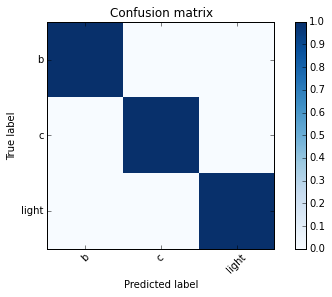

In [112]:
figsize(6, 4)
plot_confusion_matrix(cm / numpy.max(cm, axis=0))

In [113]:
labels = numpy.array([0] * len(data_b) + [1] * len(data_c) + [2] * len(data_light))

In [114]:
'log loss', -numpy.log(multi_probs[numpy.arange(len(multi_probs)), labels]).sum() / len(labels)

('log loss', 0.36531756628136025)

In [164]:
labels = numpy.array([0] * len(data_b) + [1] * len(data_c) + [2] * len(data_light))
multiclass_result = generate_result(1 - roc_auc_score(labels > 0, multi_probs[:, 0] / multi_probs[:, 1], 
                                                      sample_weight=(labels != 2) * 1),
                                    1 - roc_auc_score(labels > 1, multi_probs[:, 0] / multi_probs[:, 2],
                                                      sample_weight=(labels != 1) * 1),
                                    1 - roc_auc_score(labels > 1, multi_probs[:, 1] / multi_probs[:, 2],
                                                      sample_weight=(labels != 0) * 1),
                                    label='multiclass')

In [165]:
result = pandas.concat([baseline_result, multiclass_result])
result.index = result['name']
result = result.drop('name', axis=1)
result

,b vs c,b vs light,c vs light
name,,,
baseline,0.947633,0.982257,0.972115
multiclass,0.948198,0.983877,0.973912


In [117]:
multi_probs_b = multi_probs[:len(data_b), :]  
multi_probs_c = multi_probs[len(data_b) : len(data_b) + len(data_c), :]
multi_probs_light = multi_probs[len(data_b) + len(data_c):, :]

# One vs All

### b vs all

In [122]:
data_b_vs_all = pandas.concat([data_b, data_c, data_light], axis=0)
label_b_vs_all = numpy.array([1]*len(data_b) + [0]*len(data_c) + [0]*len(data_light))
data_b_vs_all_lds = LabeledDataStorage(data_b_vs_all, label_b_vs_all)

In [126]:
xgb_base = XGBoostClassifier(n_estimators=100, colsample=0.7, eta=0.1, nthreads=8, subsample=0.5, max_depth=8)
b_vs_all_folding = FoldingClassifier(xgb_base, n_folds=2, random_state=11, features=sv_features)
%time b_vs_all_folding.fit_lds(data_b_vs_all_lds)

CPU times: user 22.5 s, sys: 2.62 s, total: 25.1 s
Wall time: 10.3 s


FoldingClassifier(base_estimator=XGBoostClassifier(base_score=0.5, colsample=0.7, eta=0.1, features=None,
         gamma=None, max_depth=8, min_child_weight=1.0, missing=-999.0,
         n_estimators=100, nthreads=8, num_feature=None, random_state=0,
         scale_pos_weight=1.0, subsample=0.5, verbose=0),
         features=['SVM', 'SVMC', 'SVR', 'SVPT', 'SVDR', 'SVN', 'SVQ', 'SVFDChi2', 'SVSumIPChi2', 'log_SVFDChi2', 'log_SVSumIPChi2'],
         n_folds=2, parallel_profile=None, random_state=11)

In [129]:
b_vs_all_proba = b_vs_all_folding.predict_proba(data_b_vs_all)
roc_auc_score(label_b_vs_all, b_vs_all_proba[:,1])

KFold prediction using folds column


0.95320839339597252

### c vs all

In [130]:
data_c_vs_all = pandas.concat([data_b, data_c, data_light], axis=0)
label_c_vs_all = numpy.array([0]*len(data_b) + [1]*len(data_c) + [0]*len(data_light))
data_c_vs_all_lds = LabeledDataStorage(data_c_vs_all, label_c_vs_all)

In [131]:
xgb_base = XGBoostClassifier(n_estimators=100, colsample=0.7, eta=0.1, nthreads=8, subsample=0.5, max_depth=8)
c_vs_all_folding = FoldingClassifier(xgb_base, n_folds=2, random_state=11, features=sv_features)
%time c_vs_all_folding.fit_lds(data_c_vs_all_lds)

CPU times: user 22.4 s, sys: 2.56 s, total: 25 s
Wall time: 10.2 s


FoldingClassifier(base_estimator=XGBoostClassifier(base_score=0.5, colsample=0.7, eta=0.1, features=None,
         gamma=None, max_depth=8, min_child_weight=1.0, missing=-999.0,
         n_estimators=100, nthreads=8, num_feature=None, random_state=0,
         scale_pos_weight=1.0, subsample=0.5, verbose=0),
         features=['SVM', 'SVMC', 'SVR', 'SVPT', 'SVDR', 'SVN', 'SVQ', 'SVFDChi2', 'SVSumIPChi2', 'log_SVFDChi2', 'log_SVSumIPChi2'],
         n_folds=2, parallel_profile=None, random_state=11)

In [132]:
c_vs_all_proba = c_vs_all_folding.predict_proba(data_c_vs_all)
roc_auc_score(label_c_vs_all, c_vs_all_proba[:,1])

KFold prediction using folds column


0.94993486775627634

### light vs all

In [133]:
data_light_vs_all = pandas.concat([data_b, data_c, data_light], axis=0)
label_light_vs_all = numpy.array([0]*len(data_b) + [0]*len(data_c) + [1]*len(data_light))
data_light_vs_all_lds = LabeledDataStorage(data_light_vs_all, label_light_vs_all)

In [134]:
xgb_base = XGBoostClassifier(n_estimators=100, colsample=0.7, eta=0.1, nthreads=8, subsample=0.5, max_depth=8)
light_vs_all_folding = FoldingClassifier(xgb_base, n_folds=2, random_state=11, features=sv_features)
%time light_vs_all_folding.fit_lds(data_light_vs_all_lds)

CPU times: user 22.5 s, sys: 2.62 s, total: 25.2 s
Wall time: 10.2 s


FoldingClassifier(base_estimator=XGBoostClassifier(base_score=0.5, colsample=0.7, eta=0.1, features=None,
         gamma=None, max_depth=8, min_child_weight=1.0, missing=-999.0,
         n_estimators=100, nthreads=8, num_feature=None, random_state=0,
         scale_pos_weight=1.0, subsample=0.5, verbose=0),
         features=['SVM', 'SVMC', 'SVR', 'SVPT', 'SVDR', 'SVN', 'SVQ', 'SVFDChi2', 'SVSumIPChi2', 'log_SVFDChi2', 'log_SVSumIPChi2'],
         n_folds=2, parallel_profile=None, random_state=11)

In [135]:
light_vs_all_proba = light_vs_all_folding.predict_proba(data_light_vs_all)
roc_auc_score(label_light_vs_all, light_vs_all_proba[:,1])

KFold prediction using folds column


0.97725391782401461

### class probas

In [161]:
class_probas = numpy.concatenate((b_vs_all_proba[:,[1]], c_vs_all_proba[:,[1]], light_vs_all_proba[:,[1]]), axis=1)
class_probas = class_probas/class_probas.sum(axis=1, keepdims=True)
class_labels = numpy.array([0]*len(data_b) + [1]*len(data_c) + [2]*len(data_light))

In [168]:
one_vs_all_result = generate_result(1 - roc_auc_score(class_labels > 0, class_probas[:, 0] / class_probas[:, 1], 
                                                      sample_weight=(class_labels != 2) * 1),
                                    1 - roc_auc_score(class_labels > 1, class_probas[:, 0] / class_probas[:, 2],
                                                      sample_weight=(class_labels != 1) * 1),
                                    1 - roc_auc_score(class_labels > 1, class_probas[:, 1] / class_probas[:, 2],
                                                      sample_weight=(class_labels != 0) * 1),
                                    label='one_vs_all')

In [169]:
result = pandas.concat([baseline_result, multiclass_result, one_vs_all_result])
result.index = result['name']
result = result.drop('name', axis=1)
result

,b vs c,b vs light,c vs light
name,,,
baseline,0.947633,0.982257,0.972115
multiclass,0.948198,0.983877,0.973912
one_vs_all,0.947602,0.983887,0.974016
